# Where do we start

WHY
Non-linearity to use Universal approximation theorum http://mcneela.github.io/machine_learning/2017/03/21/Universal-Approximation-Theorem.html

Criteria:
symmetric
monotonous
vanishing gradient
output not zero centered (optimization harder)
saturation --> vanishing gradient

order of continuity
monotonic
monotonic derivative
saturated
identity approx at origin

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import math
import warnings
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 5]

In [3]:
def step(x):
    y = torch.ones(x.shape)
    y[torch.where(x < 0)] = -1
    return y

def swish(x, beta=1):
    return x * torch.sigmoid(beta * x)

def mish(x):
    return x * torch.tanh(F.softplus(x))

## Normalized input

In [4]:
def investigate_act(fn, val_range, step=0.1, nb_samples=10000, title=None):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    x_range = torch.arange(*val_range, step, requires_grad=True)
    x = torch.randn(nb_samples)
    ax1.hist(x, 100, alpha=0.5)
    ax1_label = f'(mean, std): ({x.mean():.5}, {x.std():.5})'

    _y = fn(x_range)
    ax2.plot(x_range.detach().numpy(), _y.detach().numpy())
    # Get derivative
    try:
        _y.sum().backward()
        ax2.plot(x_range.detach().numpy(), x_range.grad.detach().numpy())
    except:
        warnings.warn('Non-defined derivative')
    
    y = fn(x)
    ax3.hist(y, 100, alpha=0.5)
    ax3_label = f'(mean, std): ({y.mean():.5}, {y.std():.5})'
    
    try:
        grad_x = torch.randn(nb_samples, requires_grad=True)
        grad_y = fn(grad_x)
        grad_y.sum().backward()
        ax3.hist(grad_x.detach().numpy(), 100, alpha=0.5)
        ax1.hist(grad_x.grad.detach().numpy(), 100, alpha=0.5)
        ax1_label += f'\n(mean, std): {grad_x.grad.mean().item():.5}, {grad_x.grad.std().item():.5})'
        ax3_label += f'\n(mean, std): {grad_y.grad.mean().item():.5}, {grad_y.grad.std().item():.5})'
    except Exception as e:
        warnings.warn('Non-defined derivative')
        print(e)
    
    ax1.title.set_text(f'Input distribution\n(samples: {nb_samples})')
    ax1.set_xlabel(ax1_label)
    ax1.legend(['Activation inflow', 'Gradient outflow'])
    
    ax2.title.set_text('Activation')
    ax2.legend(['Value', 'Derivative'])
    
    ax3.title.set_text(f'Output distribution\n(samples: {nb_samples})')
    ax3.set_xlabel(ax3_label)
    ax3.legend(['Output activation', 'Gradient inflow'])
    
    
    if isinstance(title, str):
        fig.suptitle(title, fontsize='xx-large', weight='bold')

In [5]:
plt.rcParams['figure.figsize'] = [15, 5]

/home/fg/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Non-defined derivative
  from ipykernel import kernelapp as app
/home/fg/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Non-defined derivative


element 0 of tensors does not require grad and does not have a grad_fn


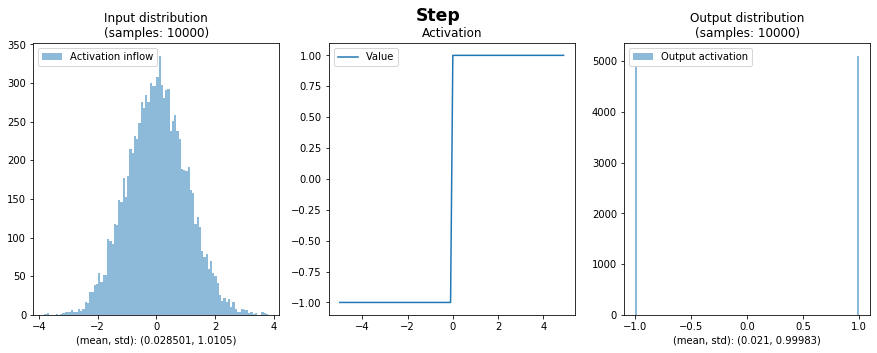

'NoneType' object has no attribute 'mean'


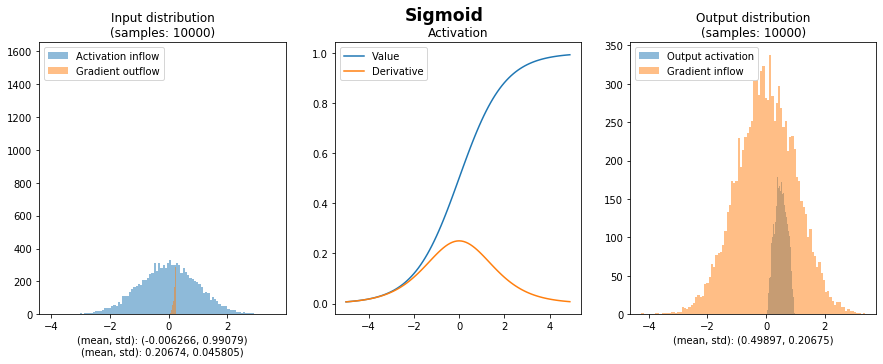

'NoneType' object has no attribute 'mean'


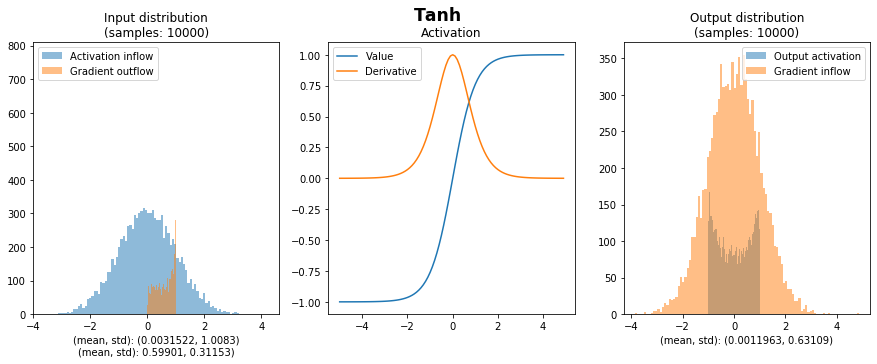

'NoneType' object has no attribute 'mean'


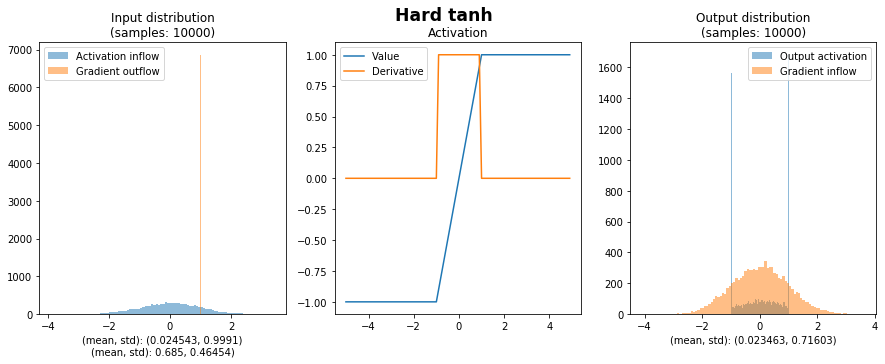

'NoneType' object has no attribute 'mean'


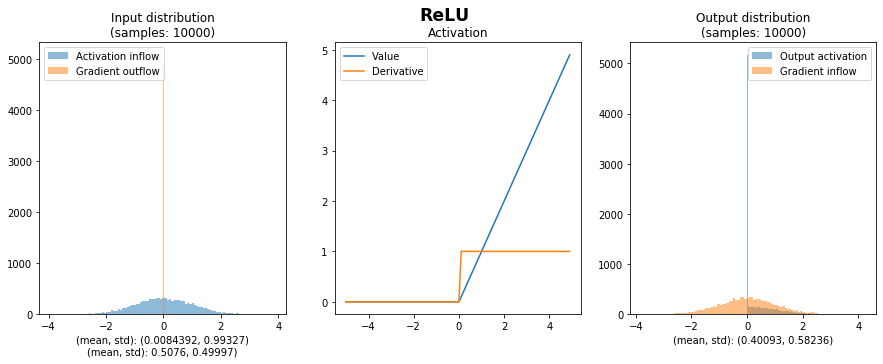

'NoneType' object has no attribute 'mean'


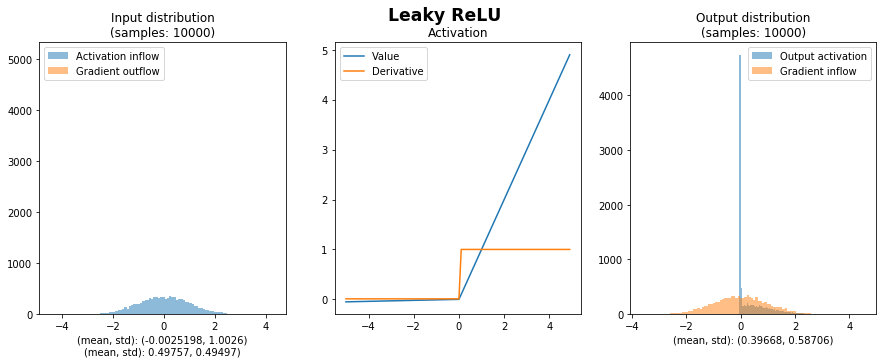

'NoneType' object has no attribute 'mean'


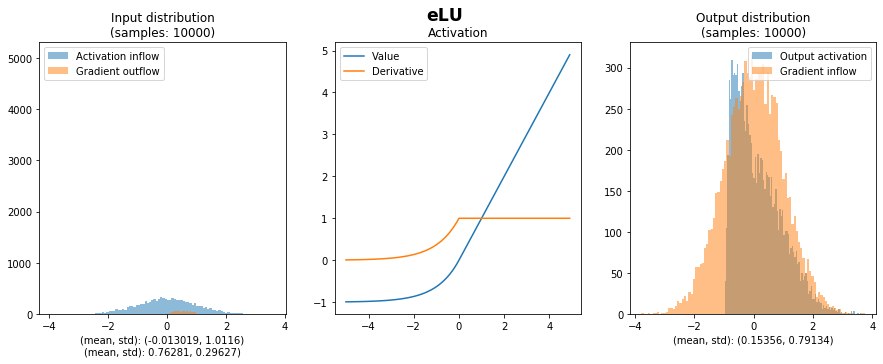

'NoneType' object has no attribute 'mean'


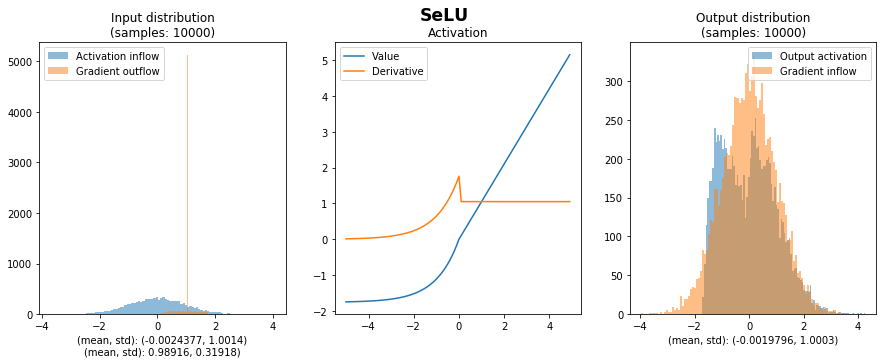

'NoneType' object has no attribute 'mean'


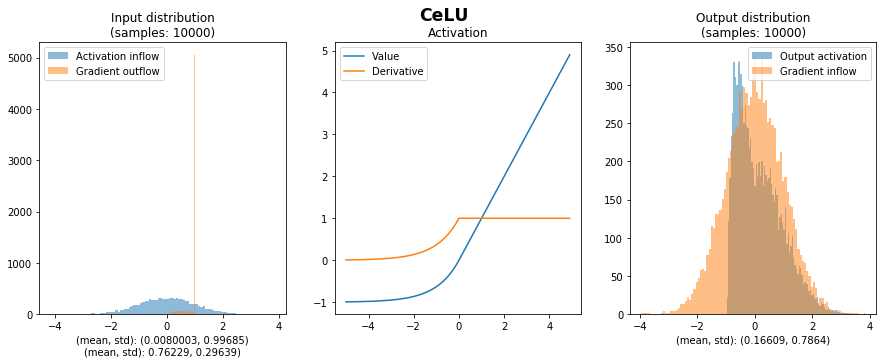

'NoneType' object has no attribute 'mean'


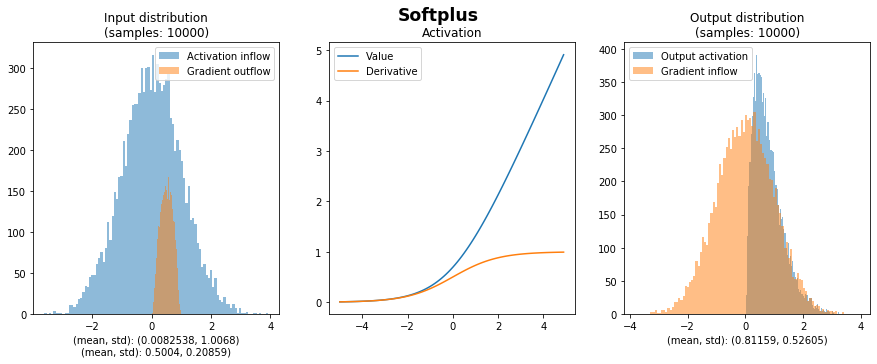

'NoneType' object has no attribute 'mean'


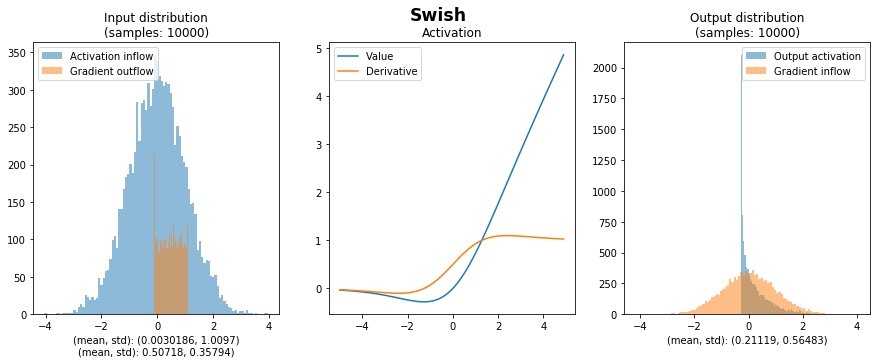

'NoneType' object has no attribute 'mean'


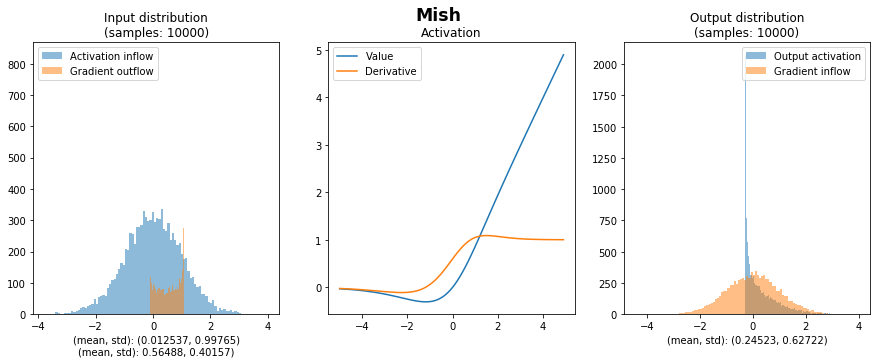

In [6]:
act_fns = [('Step', step), ('Sigmoid', torch.sigmoid), ('Tanh', torch.tanh), ('Hard tanh', F.hardtanh),
           ('ReLU', F.relu), ('Leaky ReLU', F.leaky_relu), ('eLU', F.elu), ('SeLU', F.selu),
           ('CeLU', F.celu), ('Softplus', F.softplus), ('Swish', swish), ('Mish', mish)]

for n, fn in act_fns:
    investigate_act(fn, (-5, 5), title=n)
    plt.show()

## Evaluating activations
Few criterias:
- non-linear
- saturation
- zero-centered
- monotonic
- order of continuity
- identity approx at origin
- computation

In [7]:
class Activation(nn.Module):
    
    def __init__(self, act_fn):
        super().__init__()
        self.act_fn = act_fn
    
    def forward(self, x):
        return self.act_fn(x)


def seq_model(fc_nodes, act_fn):
    layers = []
    for idx, nodes in enumerate(fc_nodes[1:]):
        layers.extend([nn.Linear(fc_nodes[idx], nodes), Activation(act_fn)])
    
    return nn.Sequential(*layers)

In [8]:
in_nodes, out_nodes = 512, 32

In [9]:
def group_sum(x, fn, group_size=16):
    target = torch.empty(math.ceil(x.shape[0] / group_size))
    for idx in range(out_nodes):
        target[idx] = fn(x[16 * idx: min(16 * (idx+2), x.shape[0])].sum())
    return target


In [10]:
epochs = 10
ds_size = 32000
val_size = 8000
bs = 32
lr = 5e-4

In [11]:
def train(model, epochs, ds_size, val_size, bs, criterion, optimizer):
    losses = []

    for epoch in range(epochs):
        tot_loss = 0
        model.train()
        for _ in range(ds_size // bs):
            input_t = torch.randn(in_nodes)
            target = group_sum(input_t, math.sin, group_size=in_nodes//out_nodes)
            input_t, target = input_t.cuda(), target.cuda()
            out = model(input_t)
            batch_loss = criterion(out, target)

            optimizer.zero_grad()
            batch_loss.backward()
            optimizer.step()

            tot_loss += batch_loss.item()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for _ in range(val_size // bs):
                input_t = torch.randn(in_nodes)
                target = group_sum(input_t, math.sin, group_size=in_nodes//out_nodes)
                input_t, target = input_t.cuda(), target.cuda()
                out = model(input_t)
                batch_loss = criterion(out, target)
                val_loss += batch_loss.item()
        losses.append(val_loss/(val_size // bs))
        # print(f"Epoch {epoch+1}/{epochs} - Loss: {tot_loss/(ds_size // bs):.5} - Val: {val_loss/(val_size // bs):.5}")

    plt.plot(range(len(losses)), losses)
    plt.show()

In [12]:
criterion = nn.MSELoss()
model = seq_model([in_nodes, 256, out_nodes], torch.sigmoid).train().cuda()
optimizer = optim.Adam(model.parameters(), lr=lr, momentum=0.9)
train(model, epochs, ds_size, val_size, bs, criterion, optimizer)

TypeError: __init__() got an unexpected keyword argument 'momentum'

In [ ]:
criterion = nn.MSELoss()
model = seq_model([in_nodes, 256, out_nodes], nn.functional.relu).train().cuda()
optimizer = optim.Adam(model.parameters(), lr=lr)
train(model, epochs, ds_size, val_size, bs, criterion, optimizer)

In [ ]:
def exp1(x):
    return x * leaky_relu(0.5*x+1.7)/3

def exp2(x):
    
    return 0.2 * x * (3 + 2 * relu(x))